In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from statsforecast.models import AutoETS, WindowAverage, DynamicOptimizedTheta
from statsforecast.core import StatsForecast
from utilsforecast.evaluation import evaluate
from typing import List

In [4]:
sales = pd.read_csv("inputs/Phase 0 - Sales.csv", na_values=np.nan)
df = sales.set_index(["Client", "Warehouse","Product"]).stack().reset_index()
df["unique_id"] = df["Client"].astype(str) + "/" + df["Warehouse"].astype(str) + "/" + df["Product"].astype(str)
df = df.drop(columns =  ["Client", "Warehouse", "Product"])
df.columns = ["ds", "y", "unique_id"]
df["ds"] = pd.to_datetime(df["ds"])

In [10]:
# Model inputs
HORIZON = 13
ANNUAL_SEASONAL_VALUE=52
MONTHLY_SEASONAL_VALUE=4
FORECAST_STEPS=13
freq = "W-MON"

In [39]:
# We use AutoETS (runs in about 2 minutes on my machine (i7-12700k))
sf = StatsForecast(
                     models=[
                            AutoETS(model='ZZZ', alias="BasicETS"),
                            AutoETS(season_length=ANNUAL_SEASONAL_VALUE, alias='AutoETS_52'),
                            WindowAverage(window_size=MONTHLY_SEASONAL_VALUE, alias='MovingA_4'),
                            WindowAverage(window_size=ANNUAL_SEASONAL_VALUE, alias='MovingA_52'),
                            DynamicOptimizedTheta(season_length=ANNUAL_SEASONAL_VALUE, alias='DOT_52')
                             ],
                     freq=freq,
                     n_jobs=-1,
                     verbose=True)

In [5]:
# We use the competition metric to evaluate our cross-validation predictions.
def CompetitionMetric(
    df: pd.DataFrame,
    models: List[str],
    id_col: str = "unique_id",
    target_col: str = "y",
) -> pd.DataFrame:
    """Computes the competition metric"""

    error = df[models].sub(df[target_col], axis=0)

    sum_abs_error = error[models].abs().sum(axis=0)
    abs_sum_error = error[models].sum(axis=0).abs()
    score = sum_abs_error + abs_sum_error
    score /= df[target_col].sum()

    score.index.name = id_col
    score = score.reset_index()
    return score

In [87]:
# Cross-validation run
yhat_cv = sf.cross_validation(
                        df=df,
                         n_windows=1,
                         h=HORIZON,
                         step_size=13,
                         refit=True)

# Enforce non-negativity
yhat_cv[str(sf.models[0])] = yhat_cv[str(sf.models[0])].clip(0)

# Evaluate the cross-validation set on the competition metric
cv_metric = evaluate(
    yhat_cv.drop(columns=['cutoff']),
    metrics=[CompetitionMetric],
)
print(f"{cv_metric}")

Cross Validation Time Series 37: 100%|██████████| 1/1 [00:00<00:00, 121.46it/s]

Cross Validation Time Series 41: 100%|██████████| 1/1 [00:00<00:00, 162.97it/s]

Cross Validation Time Series 88: 100%|██████████| 1/1 [00:00<00:00, 83.15it/s]]

Cross Validation Time Series 98: 100%|██████████| 1/1 [00:00<00:00, 123.15it/s]

Cross Validation Time Series 183: 100%|██████████| 1/1 [00:00<00:00, 22.03it/s]

Cross Validation Time Series 166: 100%|██████████| 1/1 [00:00<00:00, 94.53it/s]]

Cross Validation Time Series 234: 100%|██████████| 1/1 [00:00<00:00, 110.69it/s]

Cross Validation Time Series 371: 100%|██████████| 1/1 [00:00<00:00, 50.51it/s]]

Cross Validation Time Series 332: 100%|██████████| 1/1 [00:00<00:00, 38.41it/s]

Cross Validation Time Series 334: 100%|██████████| 1/1 [00:00<00:00, 161.00it/s]

Cross Validation Time Series 402: 100%|██████████| 1/1 [00:00<00:00, 123.29it/s]

Cross Validation Time Series 432: 100%|██████████| 1/1 [00:00<00:00, 96.44it/s]

Cross Validation Time S

  unique_id             metric         0
0   AutoETS  CompetitionMetric  0.524427


Cross Validation Time Series 1805: 100%|██████████| 1/1 [00:00<00:00, 116.06it/s]

Cross Validation Time Series 1763: 100%|██████████| 1/1 [00:00<00:00, 155.83it/s]
Cross Validation Time Series 1764:   0%|     

In [15]:
evaluate(
    yhat_cv.drop(columns=['cutoff']),
    metrics=[CompetitionMetric],
)

,unique_id,metric,0
0,AutoETS,CompetitionMetric,0.550454


In [40]:
# Fit the model
sf.fit(df = df)

# Generate test predictions
yhat_test = sf.predict(h=HORIZON)
yhat_test = yhat_test.reset_index()

# Enforce non-negativity
for model in sf.models:
    yhat_test[str(model)] = yhat_test[str(model)].clip(0)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

In [34]:
yhat_test

,unique_id,ds,BasicETS,AutoETS_52,MovingA_52,DOT_52,Client,Warehouse,Product
0,0/1/10705,2023-10-09,3.482906,3.482906,2.730769,3.487568,0,1,10705
1,0/1/10705,2023-10-16,3.482906,3.482906,2.730769,3.487568,0,1,10705
2,0/1/10705,2023-10-23,3.482906,3.482906,2.730769,3.487568,0,1,10705
3,0/1/10705,2023-10-30,3.482906,3.482906,2.730769,3.487568,0,1,10705
4,0/1/10705,2023-11-06,3.482906,3.482906,2.730769,3.487568,0,1,10705
...,...,...,...,...,...,...,...,...,...
195684,9/82/9950,2023-12-04,0.005945,0.005945,0.019231,0.003815,9,82,9950
195685,9/82/9950,2023-12-11,0.005945,0.005945,0.019231,0.003815,9,82,9950
195686,9/82/9950,2023-12-18,0.005945,0.005945,0.019231,0.003815,9,82,9950
195687,9/82/9950,2023-12-25,0.005945,0.005945,0.019231,0.003815,9,82,9950


In [41]:
sf.models

[BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52]

In [42]:
def format_and_export_data(yhat_test: pd.DataFrame, model_name: str):
    # We use the name of the model
    name = f"outputs/Submission Phase 1 - {model_name}.csv"
    yhat_test = yhat_test[["unique_id", "ds", model_name]]

    # Apply some data wrangling to ensure everything is in the expected format of the competition
    yhat_test[["Client", "Warehouse", "Product"]] = yhat_test["unique_id"].str.split("/", expand=True)
    yhat_test[["Client", "Warehouse", "Product"]] = yhat_test[["Client", "Warehouse", "Product"]].astype(np.int64)
    yhat_test = yhat_test.sort_values(by=["Client", "Warehouse", "Product"]).reset_index(drop=True)
    yhat_test = yhat_test.drop(columns="unique_id")
    yhat_test = yhat_test.set_index(["Client", "Warehouse", "Product", "ds"])
    yhat_test = yhat_test.unstack(3)
    yhat_test.columns = yhat_test.columns.get_level_values(1)
    yhat_test.to_csv(name)
    return yhat_test

# Call the function with the dataframe and model name
for model in sf.models:
    output = format_and_export_data(yhat_test, str(model))

# Exploraciones

In [45]:
sf.fitted_

array([[BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52],
       [BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52],
       [BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52],
       ...,
       [BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52],
       [BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52],
       [BasicETS, AutoETS_52, MovingA_4, MovingA_52, DOT_52]],
      dtype=object)

In [47]:
# genera un dataframe con una columna que indica el id de la serie y otra columna con el metodo sf.fitted_[0,0].model_["method"]
dff = pd.DataFrame()
rows = []
for i in range(len(sf.uids)):
    # la columna method debe rellena con el metodo que se ha usado para predecir la serie
    method = sf.fitted_[i,0].model_["method"]
    rows.append({"unique_id": sf.uids[i], "method": method})
dff = pd.concat([dff, pd.DataFrame(rows)], ignore_index=True)
dff.method.value_counts()


method
ETS(A,N,N)     13065
ETS(A,A,N)      1250
ETS(A,Ad,N)      629
ETS(M,A,N)        52
ETS(M,N,N)        44
ETS(M,Ad,N)       13
Name: count, dtype: int64

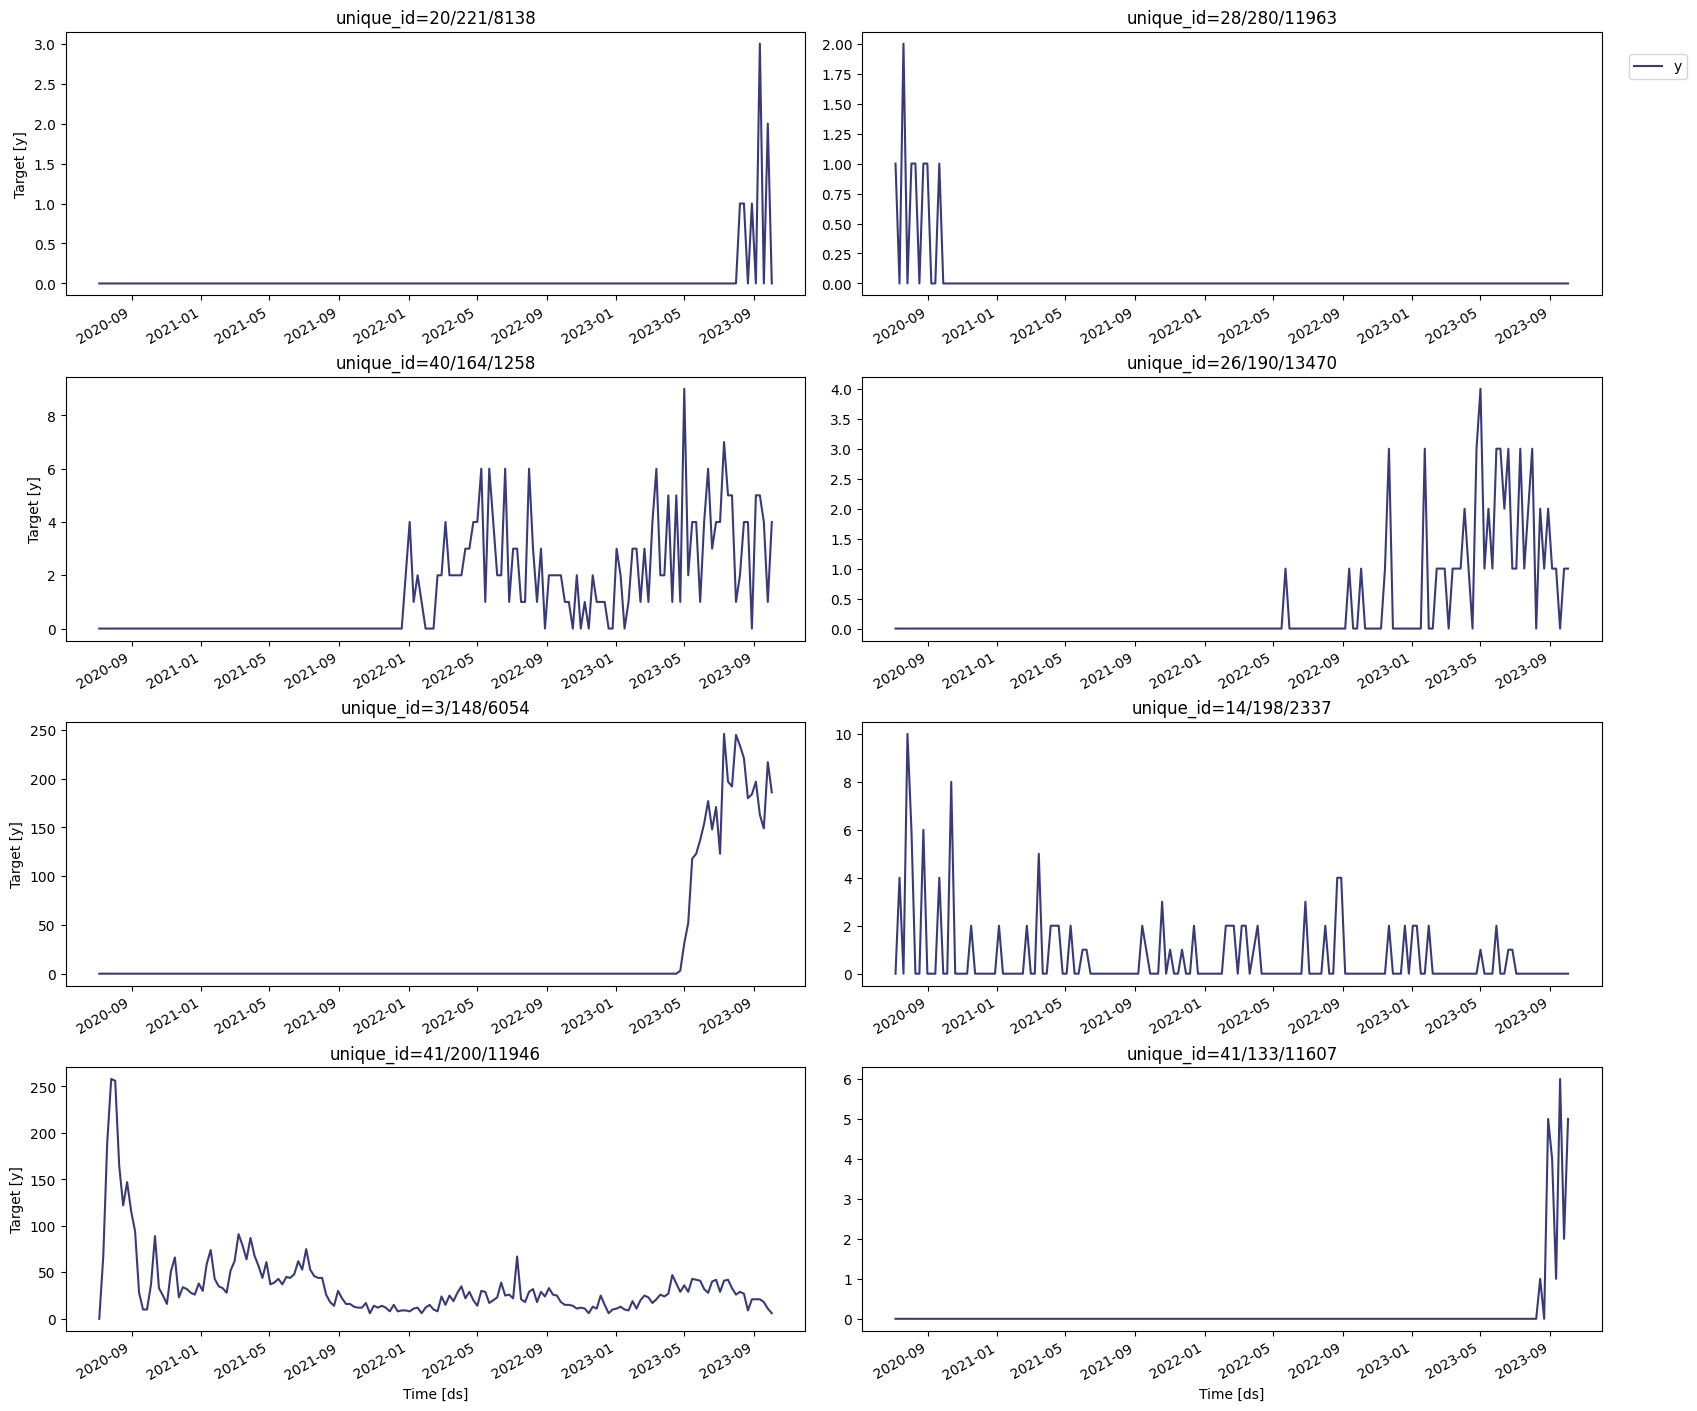

In [48]:
sf.plot(df, unique_ids=dff.query("method == 'ETS(A,Ad,N)'").unique_id.unique())
